# Daily Mean vs. Instant
The NWIS provides continuous discharge data in two different formats: 'Daily Mean Discharge' and 'Instantaneous Values'.
The Daily Mean Discharge is the average discharge for an entire day, from midnight, local time to midnight local time.
The Instantaneous Discharge is also known as 'Real Time' data. It is the current discharge at the time of the measurement. In this case, measurements can occur as often as every five minutes, but most often is every fifteen minutes.
Both Daily Mean and Instantaneous discharge values are given in units of 'cubic feet per second'.

On this page I illustrate the differences in the two datasets and show applications for each.

In [1]:
# Start our Jupyter Notebook the usual way:
import hydrofunctions as hf
import matplotlib.pyplot as plt
print(hf.__version__)
%matplotlib inline

0.2.0


## Loading Daily Values
First, let's load a month of Daily Discharge data using the 'DV', or Daily Values service.

In [2]:
daily = hf.NWIS('01589330', 'dv', '2018-06-01', '2018-07-01', file='DeadRun_Daily.parquet')

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01589330&startDT=2018-06-01&endDT=2018-07-01
Saving data to DeadRun_Daily.parquet


When we list the dataset, you can see that the discharge is collected at a daily interval.

In [3]:
daily

USGS:01589330: DEAD RUN AT FRANKLINTOWN, MD
    00060: <Day>  Discharge, cubic feet per second
Start: 2018-06-01 00:00:00+00:00
End:   2018-07-01 00:00:00+00:00

## Loading Instantaneous Values
Next, let's collect data for the same station at the same time, but we'll request the 'iv' Instantaneous Values. Note that these get collected every 5 Minutes according to the listing.

In [4]:
instant = hf.NWIS('01589330', 'iv', '2018-06-01', '2018-07-01', file='DeadRun_Instant.parquet')
instant

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=01589330&startDT=2018-06-01&endDT=2018-07-01
Saving data to DeadRun_Instant.parquet


USGS:01589330: DEAD RUN AT FRANKLINTOWN, MD
    00060: <5 * Minutes>  Discharge, cubic feet per second
    00065: <5 * Minutes>  Gage height, feet
Start: 2018-06-01 04:00:00+00:00
End:   2018-07-02 03:55:00+00:00

Now, we'll put the discharge data into two dataframes, one for the Daily data, and one for the Instantaneous data. The .head() method will list the first five lines of each table.

In [5]:
# This table needs to be shifted four hours: The data are averaged over 24 hours, 
# midnight to midnight, local time (+4 UTC).
D = daily.df('q').shift(4, freq='H')
D.head()

,USGS:01589330:00060:00003
datetimeUTC,
2018-06-01 04:00:00+00:00,6.76
2018-06-02 04:00:00+00:00,13.60
2018-06-03 04:00:00+00:00,179.00
2018-06-04 04:00:00+00:00,16.20
2018-06-05 04:00:00+00:00,11.80


In [6]:
I = instant.df('q')
I.head()

,USGS:01589330:00060:00000
datetimeUTC,
2018-06-01 04:00:00+00:00,23.9
2018-06-01 04:05:00+00:00,23.1
2018-06-01 04:10:00+00:00,22.3
2018-06-01 04:15:00+00:00,21.5
2018-06-01 04:20:00+00:00,20.8


## Plotting discharge
A simple plot of the data shows that the two hydrographs are similar, but of course the Daily data were collected less often. Also, note the the peaks are lower for the daily data.

C:\Users\Marty\Anaconda3\envs\py37hfdev\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


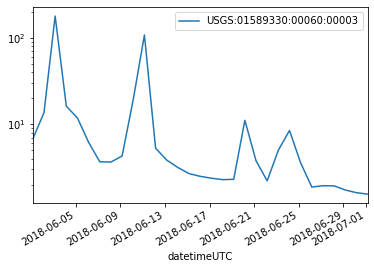

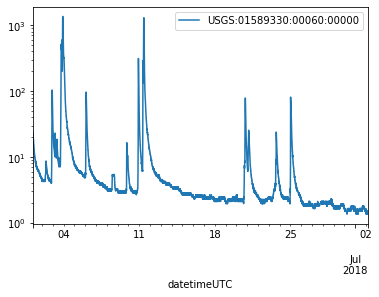

In [7]:
# Discharge data can vary over several orders of magnitude, so we usually plot it on a logarithmic scale.
D.plot(logy=True)
I.plot(logy=True)

That was nice and all, but it would be better if we could plot our data on the same graph. Also, since the daily mean discharage data represent the mean discharge over the course of an entire day, these data are better plotted with a step function.

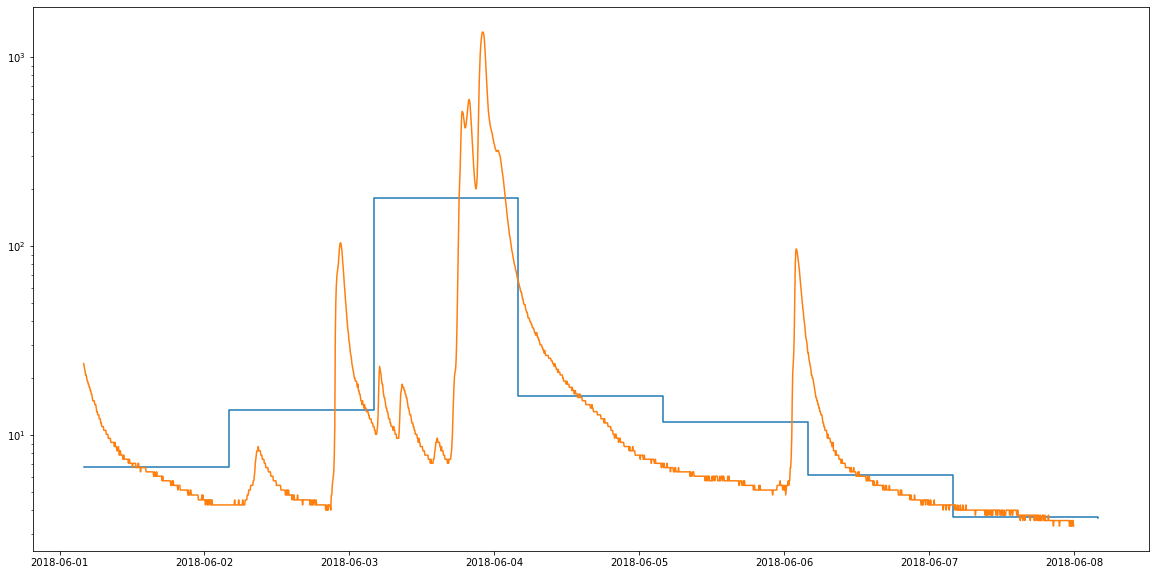

In [8]:
# A week of data
fig, ax = plt.subplots(figsize=(20, 10))
ax.step(D.loc['2018-06-01':'2018-06-08'].index.values, D.loc['2018-06-01':'2018-06-08'].values, where='post')
ax.plot(I.loc['2018-06-01':'2018-06-07'])
plt.yscale('log')

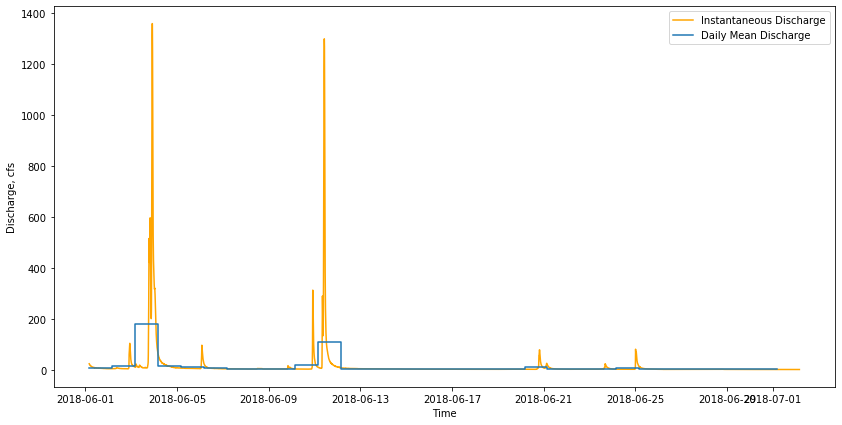

In [9]:
# Plot the entire month-long dataset.
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(I, "orange", label="Instantaneous Discharge")
ax.step(D.index.values, D.values, where='post', label="Daily Mean Discharge")
plt.xlabel('Time')
plt.ylabel('Discharge, cfs')
plt.legend()
# I've commented out the command to plot this on a logarithmic scale, but you can try it.
#plt.yscale('log')

## Why use Daily Mean or Instantaneous values?
The Instantaneous Values are the 'raw' data that gets collected at each stream gauge site. They get processed to produce the Daily Mean Discharge values.  The Daily Mean discharge data then become the 'official' data for each USGS stream gauge. These data get error-checked. 

The Daily Mean discharge data are great for situations where you want to know the baseflow of a watershed, or the volume of water that is entering a reservoir or if you want to learn about the long-term hydrology of a watershed. Daily values get used for:

- Flow Duration charts
- Water balance models
- Water quality models

The Instantaneous Values are better for examining the shape and timing of flood waves. They get used for:

- Determining the size of floods at their peak,
- and the timing of the peak
- these are compiled into the peak discharge data, which you can access with the command: `hf.peak('01589330')